In [1]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
from pathlib import Path
from scipy import stats
from sklearn.mixture import GaussianMixture

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

from dataloader import *

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

np.random.seed(1032020)

In [2]:
results = {}
for path in Path("results/pymc3/").glob("*.gz"):
#     if "y_true" in str(path):
#         continue
    results[path.stem] = np.loadtxt(path)

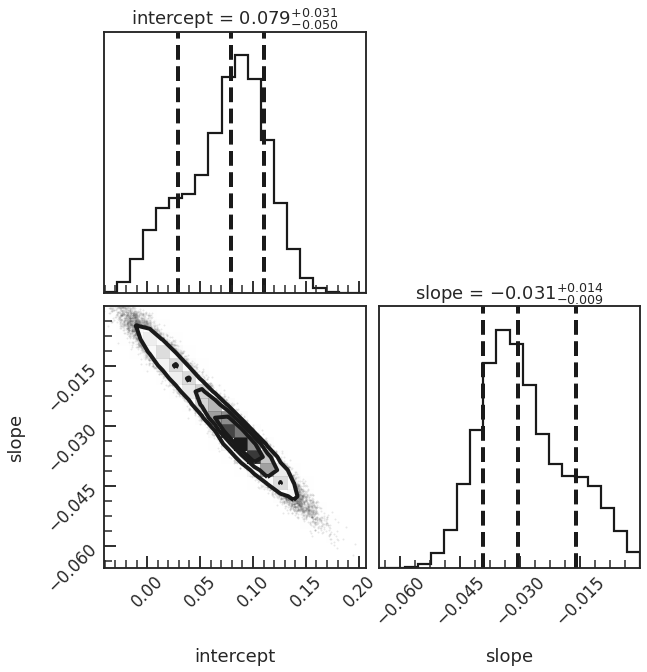

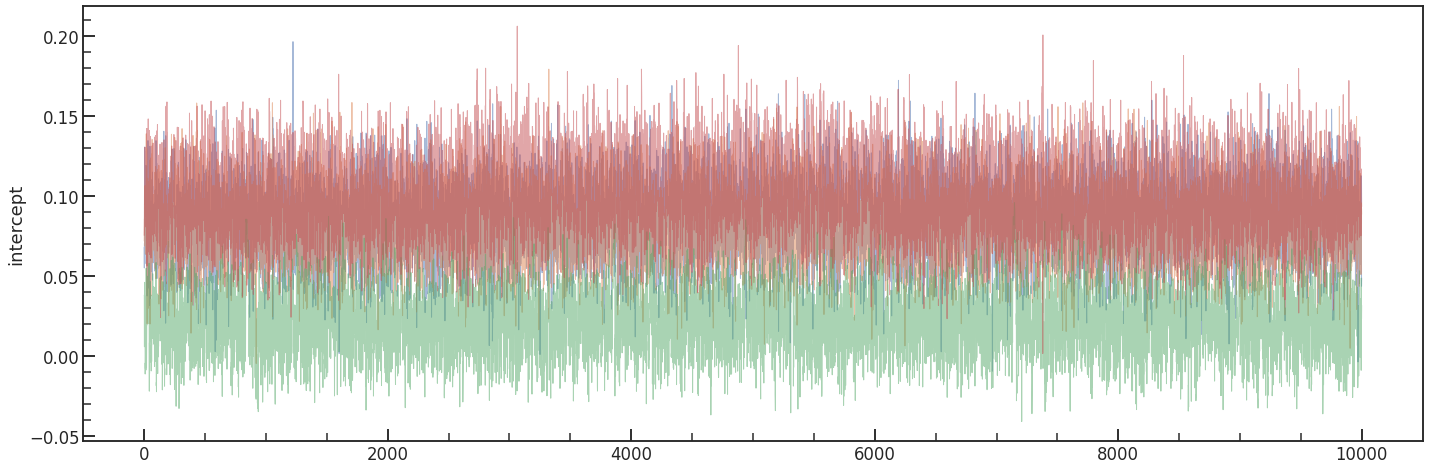

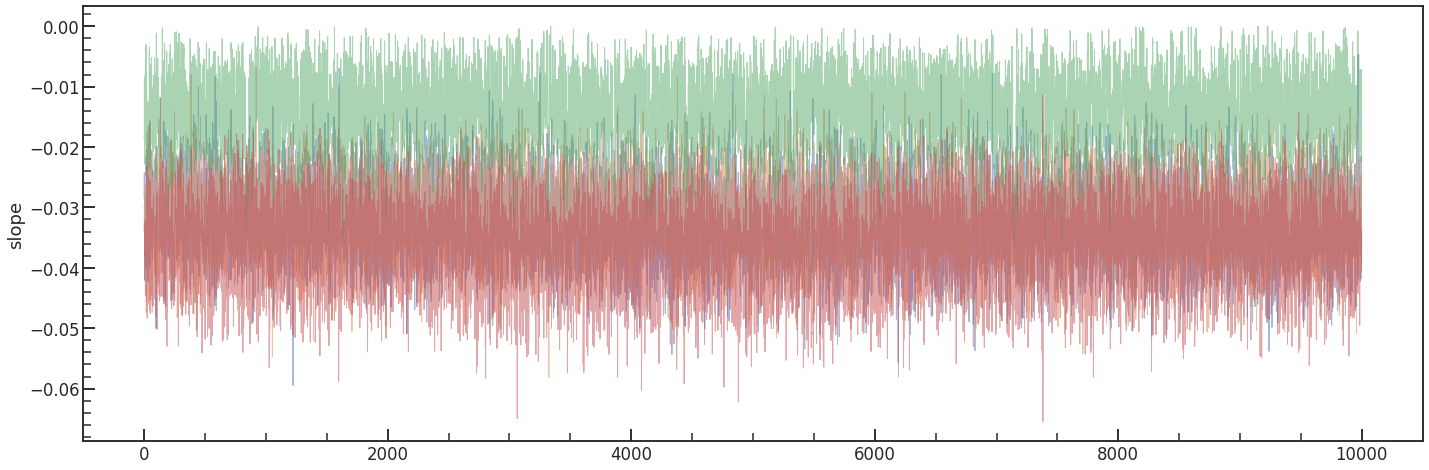

In [9]:
from corner import corner

labels = ["intercept", "slope"]
fig = plt.figure(figsize=(10, 10))
corner(np.vstack([results[k].flatten() for k in labels]).T, labels=labels, show_titles=True, title_fmt='.3f', quantiles=stats.norm.cdf([-1, 0, 1]), fig=fig);

for label in labels:
    plt.figure(figsize=(24, 8))
    plt.plot(results[label].T, lw=1, alpha=0.5)
    plt.ylabel(label)

In [2]:
size = 100
true_intercept = 1
true_slope = 2

# x1 = stats.norm(1, 1).rvs(1000)
# x2 = stats.norm(2, 1).rvs(1000)
# x3 = stats.norm(3, 1).rvs(1000)

x_true = np.linspace(0, 1, size) 
y_true = true_intercept + x_true * true_slope
x1 = np.random.normal(loc=x_true, scale=0.1, size=(10000, len(y_true))).T
x2 = np.random.normal(loc=x_true+1, scale=0.1, size=(10000, len(y_true))).T
x = np.hstack((x1, x2))

sigma_y = np.abs(np.random.normal(loc=0.5, scale=0.1, size=len(y_true)))
y_err = np.random.normal(scale=sigma_y, size=len(y_true))

y = y_true + y_err

display(pd.DataFrame({"y":y}).head())
# plt.errorbar(x, y, yerr=sigma_y, fmt='ko', lw=0.5, ms=5)
# plt.plot(x, y_true)

,y
0,0.848001
1,1.065333
2,0.973161
3,-0.089537
4,1.009119


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


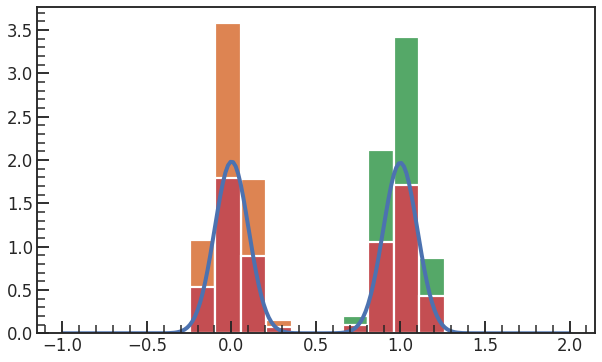

In [3]:
gmms = []
for i in trange(x.shape[0]):
    gmm = GaussianMixture(n_components=2, covariance_type='spherical').fit(x[i].reshape(len(x[i]), -1))
    gmms.append(gmm)
    
xrange = np.linspace(-1, 2, 200).reshape(-1, 1)
plt.plot(xrange, np.exp(gmms[0].score_samples(xrange)))
bins = xrange[::10].reshape(-1)
plt.hist(x1[0], bins, density=True), plt.hist(x2[0], bins, density=True), plt.hist(x[0], bins, density=True)

mu_x = np.array([gmm.means_ for gmm in gmms])
sigma_x = np.array([gmm.covariances_ for gmm in gmms])
weights_x = np.array([gmm.weights_ for gmm in gmms])

$$
y^* = \beta x^* + \alpha\\
y = y^* + \epsilon_y\\
x \sim D(x^*); E[x]=x^*
$$

In [4]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=1, sigma=0.5)
    slope = pm.Uniform('slope', 0, 5)
#     _sigma_x = pm.Uniform('sigma_x', 0, 1, shape=y.shape[0])
    _sigma_y = pm.Uniform('sigma_y', 0, 1, shape=sigma_y.shape[0], observed=sigma_y)
    scatter = pm.Uniform('scatter', 0, 5)
    total_sigma = pm.Deterministic('sigma', pm.math.sqrt(_sigma_y**2 + scatter))
    
#     _x_true = pm.Uniform('x_true', 0, 1)
#     weight = pm.Dirichlet('w', a=np.array([1, 1]))
#     _x_true = pm.Uniform('x_true', 0, 10, shape=y.shape[0])
    g1 = pm.Normal.dist(mu=mu_x[:,0], sigma=sigma_x[:,0], shape=(y.shape[0]))
    g2 = pm.Normal.dist(mu=mu_x[:,1], sigma=sigma_x[:,1], shape=(y.shape[0]))
#     gmm = pm.Normal.dist(mu=mu_x, sigma=sigma_x, shape=(y.shape[0], 2))
    _x = pm.Mixture('x', w=weights_x, comp_dists=[g1, g2], shape=(y.shape[0]))

#     likelihood_x = pm.Normal('x', mu=x.mean(axis=1), sigma=x.std(axis=1), shape=y.shape[0])
    
    _y_true = pm.Deterministic('y_true', slope * _x + intercept)
    likelihood_y = pm.Normal('y', mu=_y_true, sigma=total_sigma, observed=y)
    
    trace = pm.sample(1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, scatter, slope, intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 729 seconds.
There were 957 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.03706364271441156, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992535068724208, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
trace.varnames

['intercept',
 'slope_interval__',
 'scatter_interval__',
 'x',
 'slope',
 'scatter',
 'sigma',
 'y_true']

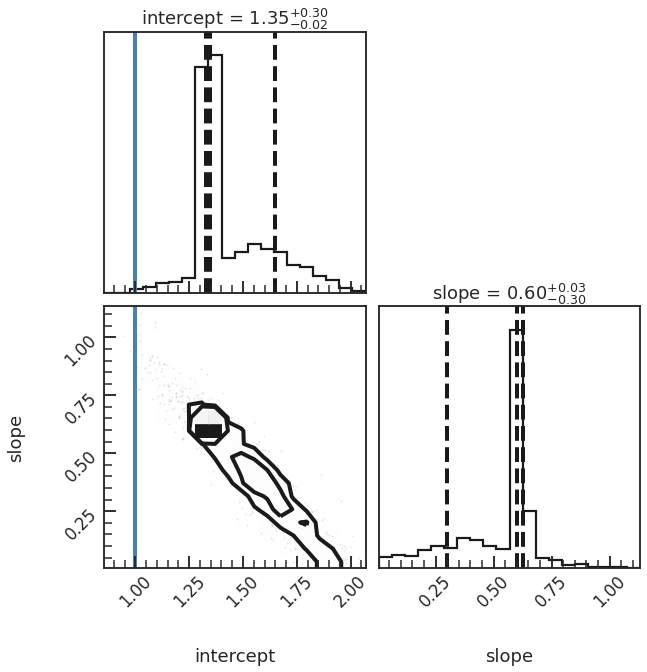

In [5]:
from corner import corner

labels = ["intercept", "slope"]
fig = plt.figure(figsize=(10, 10))
corner(np.vstack([trace[k] for k in labels]).T, labels=labels, show_titles=True, truths=[true_intercept, true_slope], quantiles=stats.norm.cdf([-1, 0, 1]), fig=fig);

# fig = plt.figure()
# pm.traceplot(trace)

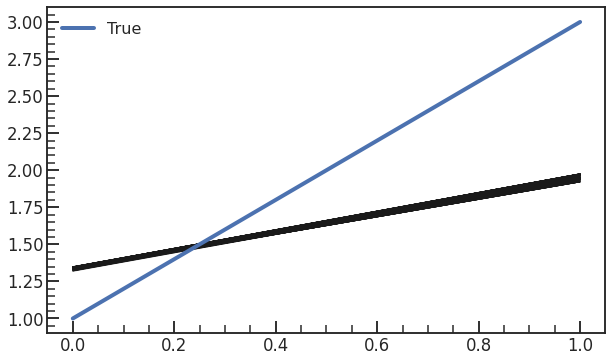

In [6]:
# plt.errorbar(x, y, yerr=sigma_y, fmt='ko', lw=0.5, ms=5)

xrange = np.linspace(0, 1, 1000)
idx = np.random.randint(0, len(trace), 500)

plt.plot(xrange, true_intercept + true_slope * xrange, label="True", zorder=100)
for i in idx:
    slope_est = trace.get_values('slope')[i]
    intercept_est = trace.get_values('intercept')[i]
    plt.plot(xrange, xrange*slope_est + intercept_est, color='k', alpha=0.5, lw=0.5)


plt.legend();